# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)

## [RAMP on cell phenotyping](http://www.ramp.studio/problems/mouse_cytometry): population identification from single cell data

_Georgios Papoutsoglou (University of Crete), Balázs Kégl (CNRS)_

## Introduction


Tissue samples are mixtures of several distinct cell types, each of which performs certain activities for the maintenance of proper tissue functioning. To carry out these activites, cells of each type are programmed to produce specific sets of membrane proteins, known as markers. These markers are usually involved in activities such as communication, adhesion, or metabolism. The specificity of a marker to an activity and, concomitantly, to a cell type makes it ideal to use for separating cells into different populations. A caveat to this task is that some surface markers will often be present on more than one cell populations.

In this context, cell phenotyping is the analysis of such heterogeneous populations of cells based on the types of proteins installed on their surfaces (phenotype). The purpose of this process is to identify the presence and proportions of the various populations of interest and enable the determination of their functions in tissues. As such, cell phenotyping has led to the significant improvement of our understanding of biological mechanisms and their association with disease. 

Single-cell technologies, such as flow/mass cytometry, are able to detect and objectively measure the abundance of cell markers in hundreds of thousands of individual cells and acquire data about dozens of them in a matter of seconds. Flow cytometry platforms, for example, have been used for decades now as a research tool to distinguish different cell types in mixed populations by measuring up to 20 markers on a cell-by-cell basis. More recently, the advent of mass cytometry has pushed this limit up to more than 40 parameters, boosting the potential resolution of phenotyping.

Until today, however, the analysis of the resulting high-dimensional datasets relies on the subjective and time-consuming _gating_, that is, a manual labeling procedure whereby cells are iteratively partitioned into populations through visual inspection by an expert using a single one-dimensional histogram or a two-dimensional scatterplot at a time. This inefficiency to handle high-dimensional data has resulted in a growing interest for the development of robust computational methods that are able to identify interesting cell populations in an automated manner. In response to such need, the goal of this challenge is to develop prediction models able to **identify cell populations from single cell mass cytometry data**.


## Data synopsis

The data is from [Samusik et al.](https://www.nature.com/nmeth/journal/v13/n6/full/nmeth.3863.html) where 38 surface markers (_features_) were measured in cells from the the bone marrow of healthy mice. The samples were analyzed and independently hand-gated by experts to identify 24 immune cell populations (_classes_).

We provide a random subset of 160K cell samples (from the [>500K publicly available](https://www.dropbox.com/sh/fx83o71jmjac554/AAA5yyvE_3dKRnvQM5VoJPLba?dl=0)).

Part of these data are saved in the files _train.csv_ and _test.csv_ as follows (<i>n_samples</i> being the number of cell samples, <i>n_feat</i> being the number of features/markers and <i>cell_type</i> being class labels):

<ul>
<li> each <b>row</b> corresponds to a cell sample</li>
<li> <b>columns 1 to 38</b> contain the abundance levels of the 38 surface markers (features). Dimensions: (n_samples, n_feat)</li>
<li><b>column 39 (<i>cell_type</i>)</b> contains the population label that each cell corresponds to according to manual gating by experts. Twenty four possible values. Dimensions: (n_samples, 1)</li>
</ul>

## Data-analysis suggestions

The data provided have been normalized using internal cytometry standards. However, cytometry data are naturally log-normal, hence, a log or log-like scale is typically used to visualize and interpret the data. Commonly used scales include inverse hyperbolic sine (arcsinh), logarithmic, and logicle (also referred to as ‘‘bi-exponential’’) scales [Diggins,et al.](https://www.ncbi.nlm.nih.gov/pubmed/25979346).

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.19.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)   
* seaborn>=0.7.1

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.options.display.max_columns = 40

## Exploratory data analysis

### Loading the data

In [2]:
train_filename = 'data/train.csv.gz'
data = pd.read_csv(train_filename)
y_df = data['cell type']
X_df = data.drop(['cell type'], axis=1)
X_df.head(5)

,CD45_2,Ly6G,IgD,CD11c,F480,CD3,NKp46,CD23,CD34,CD115,CD19,CD317,CD8,Ly6C,CD4,CD11b,CD27,CD16_32,SiglecF,Foxp3,B220,CD5,FceR1a,TCRgd,CCR7,Sca1,CD49b,cKit,CD150,CD25,TCRb,CD43,CD64,CD138,CD103,IgM,CD44,MHCII,replicate
0,25.322300,-0.414878,19.072302,-0.406325,8.004113,-0.226281,-0.693795,-0.502405,0.214797,-0.651973,7.006814,1.082769,0.030035,-0.296310,-0.660964,8.775167,-0.275792,15.888521,1.915515,-0.773721,21.440584,-0.833507,4.223345,-0.597891,-0.823490,17.817902,-0.160072,1.121113,-0.836055,-0.190984,-0.014425,0.783888,1.267933,1.781378,6.060744,143.941238,1.556530,433.069550,1
1,5.688966,-0.656603,1.936562,-0.338733,-0.019797,-0.710901,-0.262018,-0.707716,-0.223714,-0.343710,-0.097053,-0.267780,1.114447,-0.147502,-0.531843,35.129585,-0.285497,368.874481,19.613203,0.662094,0.018612,-0.246291,5.381715,-0.186779,-0.510146,-0.166597,103.653893,1.673315,-0.150073,-0.253155,-0.380198,-0.738412,-0.249999,-0.345677,-0.706774,-0.649381,42.760521,0.370612,1
2,16.577675,3.037624,28.618662,-0.226679,0.698736,-0.687407,-0.594474,4.009264,-0.182212,1.097268,4.403724,0.295415,-0.489098,-0.172496,-0.383780,-0.418165,-0.393277,8.735498,4.567228,3.064497,138.576797,4.661004,1.745882,-0.504398,-0.194553,35.861137,-0.782560,-0.451337,0.265020,-0.760213,-0.633052,-0.371888,4.576766,-0.538884,-0.057883,19.495363,2.384282,501.027222,1
3,12.619972,-0.135255,-0.200250,0.760378,10.994702,0.818546,-0.435885,0.548840,6.483472,1.808445,-0.004943,-0.509837,-0.203738,4.071029,0.285222,39.121468,-0.605241,94.969742,98.702667,7.406890,-0.492408,1.794403,0.737259,-0.581589,-0.105200,0.355662,8.762753,0.326256,-0.565969,-0.392343,1.538817,2.087312,2.868069,0.666312,2.692082,1.417462,235.478745,2.039408,1
4,41.787132,-0.718017,0.239240,-0.602358,1.000802,-0.478795,-0.710591,-0.145891,10.214432,3.836318,-0.619562,207.961685,7.600501,28.485512,0.368853,-0.050024,-0.166081,1.162022,0.442354,-0.546725,73.401352,0.287523,2.637238,2.915704,15.528143,1369.792358,33.122932,0.404252,-0.776655,-0.562648,-0.677347,-0.102858,-0.533857,-0.012488,-0.681483,0.039034,18.257036,30.230536,1


In [3]:
len(X_df)

64000

In [4]:
y_df

0          IgDpos IgMpos B cells
1                    Eosinophils
2          IgDpos IgMpos B cells
3                    Eosinophils
4                           pDCs
5          IgDpos IgMpos B cells
6            Classical Monocytes
7            IgD- IgMpos B cells
8            Classical Monocytes
9         Intermediate Monocytes
10           Classical Monocytes
11           Classical Monocytes
12           Classical Monocytes
13                          pDCs
14           IgD- IgMpos B cells
15       Non-Classical Monocytes
16                     NKT cells
17           Classical Monocytes
18           Classical Monocytes
19         IgDpos IgMpos B cells
20           Classical Monocytes
21        Intermediate Monocytes
22           Classical Monocytes
23           Classical Monocytes
24           IgD- IgMpos B cells
25        Intermediate Monocytes
26                     NKT cells
27        Intermediate Monocytes
28           Classical Monocytes
29             IgM- IgD- B-cells
          

In [5]:
data.describe()

,CD45_2,Ly6G,IgD,CD11c,F480,CD3,NKp46,CD23,CD34,CD115,CD19,CD317,CD8,Ly6C,CD4,CD11b,CD27,CD16_32,SiglecF,Foxp3,B220,CD5,FceR1a,TCRgd,CCR7,Sca1,CD49b,cKit,CD150,CD25,TCRb,CD43,CD64,CD138,CD103,IgM,CD44,MHCII,replicate
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,14.990924,1.856162,10.519870,0.744739,7.199806,1.996373,0.854031,0.500074,4.374763,3.383336,2.544937,5.845469,3.707274,56.651162,9.217409,68.020534,4.763361,66.271558,10.252683,0.745636,37.702787,9.788307,1.241115,0.039797,1.054302,45.340457,2.212637,5.371156,0.540267,0.289413,2.526127,21.150531,6.838903,0.880665,0.239405,46.072885,120.200804,162.636111,2.500000
std,13.730517,2.710905,24.678614,4.300934,18.859903,9.405244,2.409622,2.160729,18.159928,5.350769,5.472448,28.268440,22.687939,99.233057,50.442712,108.814925,17.561078,81.241472,26.909076,2.235865,68.542703,49.315548,3.924156,1.316292,2.854488,212.254998,14.186391,30.554093,1.961203,2.062137,12.836736,58.417741,20.391171,2.625042,1.536848,227.901719,120.013352,350.503770,1.118043
min,0.688541,-0.961212,-0.955516,-0.957656,-0.963544,-0.954649,-0.957595,-0.955024,-0.963577,-0.957363,-0.955344,-0.956809,-0.956715,-0.961685,-0.958159,-0.956260,-0.962440,-0.936660,-0.961858,-0.952520,-0.952209,-0.954849,-0.961525,-0.958681,-0.953416,-0.955167,-0.960603,-0.955560,-0.960407,-0.954603,-0.959976,-0.955918,-0.955013,-0.955370,-0.960537,-0.952233,-0.927464,-0.951164,1.000000
25%,6.138587,0.021828,-0.458477,-0.532739,0.031501,-0.501069,-0.428413,-0.525818,-0.184206,0.265223,-0.426032,-0.522950,-0.506049,-0.104224,-0.383094,-0.042794,-0.358163,14.419598,0.244718,-0.427223,-0.266084,0.191124,-0.310505,-0.558397,-0.362051,-0.160783,-0.512258,-0.475403,-0.470028,-0.525302,-0.487358,-0.055279,0.473218,-0.382427,-0.513516,-0.031417,12.697038,2.779469,1.750000
50%,11.285681,1.125305,-0.070340,-0.218408,1.919865,-0.161698,-0.018963,-0.208224,0.795588,1.776719,-0.002770,-0.206211,-0.172397,7.166169,0.232776,15.101614,0.323724,39.586920,1.934582,-0.018602,0.976149,1.474529,0.361529,-0.269955,0.239995,1.032405,-0.178287,-0.106894,-0.097116,-0.205850,-0.134647,2.225038,2.404246,0.140192,-0.185953,1.577631,92.549377,8.538497,2.500000
75%,19.368626,2.879700,2.622732,0.462946,7.214267,0.655443,1.166935,0.522239,3.085984,4.567230,3.175143,0.498927,0.640204,75.573193,2.198896,95.450727,2.387471,89.560493,5.653902,1.043876,45.180740,4.057003,1.603233,0.095968,1.478141,6.054978,0.639575,1.202934,0.766721,0.423269,0.658424,15.104270,6.757323,1.274122,0.479075,26.643014,195.627972,129.669563,3.250000
max,265.992279,99.542442,251.426910,224.745270,695.577881,210.105545,93.540810,40.675377,448.542725,187.677826,102.085670,531.240967,635.897156,1738.424683,1370.197998,1060.519409,329.541473,2177.363281,495.177490,98.660614,728.970642,1731.524658,192.000076,95.524033,317.294464,3111.860107,653.011597,1157.092041,83.264595,251.272598,315.617554,1108.835693,1115.901001,132.380600,109.629303,7138.376465,3007.350342,6066.360840,4.000000


In [6]:
data.count()

CD45_2       64000
Ly6G         64000
IgD          64000
CD11c        64000
F480         64000
CD3          64000
NKp46        64000
CD23         64000
CD34         64000
CD115        64000
CD19         64000
CD317        64000
CD8          64000
Ly6C         64000
CD4          64000
CD11b        64000
CD27         64000
CD16_32      64000
SiglecF      64000
Foxp3        64000
B220         64000
CD5          64000
FceR1a       64000
TCRgd        64000
CCR7         64000
Sca1         64000
CD49b        64000
cKit         64000
CD150        64000
CD25         64000
TCRb         64000
CD43         64000
CD64         64000
CD138        64000
CD103        64000
IgM          64000
CD44         64000
MHCII        64000
cell type    64000
replicate    64000
dtype: int64

In [7]:
np.unique(y_df)

array(['B-cell Frac A-C (pro-B cells)', 'Basophils', 'CD4 T cells',
       'CD8 T cells', 'CLP', 'CMP', 'Classical Monocytes', 'Eosinophils',
       'GMP', 'HSC', 'IgD- IgMpos B cells', 'IgDpos IgMpos B cells',
       'IgM- IgD- B-cells', 'Intermediate Monocytes', 'MEP', 'MPP',
       'Macrophages', 'NK cells', 'NKT cells', 'Non-Classical Monocytes',
       'Plasma Cells', 'gd T cells', 'mDCs', 'pDCs'], dtype=object)

### Predicting cell type

The goal is to predict the cell type. Let us group the data according to the `cell type` columns:

In [8]:
counts = data.groupby('cell type').count()['CD45_2']
counts.sort_values()

cell type
HSC                                  3
gd T cells                          46
CLP                                 53
mDCs                               123
MPP                                171
Plasma Cells                       190
CMP                                257
Macrophages                        309
NK cells                           348
B-cell Frac A-C (pro-B cells)      471
Basophils                          498
MEP                                615
CD4 T cells                        705
GMP                                861
NKT cells                         1083
Non-Classical Monocytes           1130
CD8 T cells                       1462
IgM- IgD- B-cells                 1916
pDCs                              3389
IgD- IgMpos B cells               5273
Eosinophils                       7117
Intermediate Monocytes           10454
IgDpos IgMpos B cells            13582
Classical Monocytes              13944
Name: CD45_2, dtype: int64

The class distribution is very unbalanced which explains why we will measure the performance with balanced accuracy aka macro-averaged recall.

### Some plots

#### Features densities and co-evolution
A scatterplot matrix allows us to visualize:
* on the diagonal, the density estimation for each feature
* on each of the off-diagonal plots, a scatterplot between two features. Each dot represents an instance.

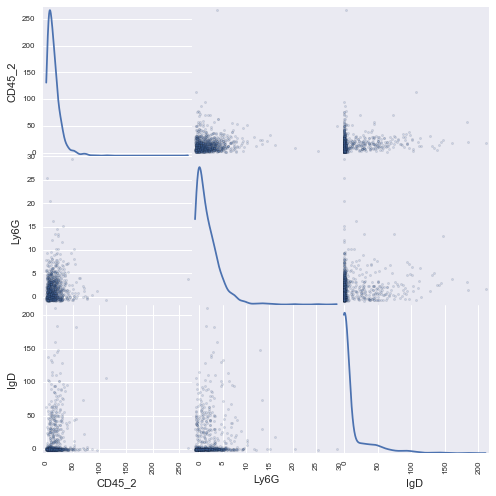

In [9]:
from pandas.tools.plotting import scatter_matrix

data_plot = data[['CD45_2', 'Ly6G', 'IgD', 'cell type']].iloc[
    np.random.choice(len(data), 1000)]

scatter_matrix(data_plot, alpha=0.2,
               figsize=(8, 8), diagonal='kde');

#### Plot the bivariate distributions and marginals of two variables 

Another way of visualizing relationships between variables is to plot their bivariate distributions.

/Users/kegl/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/kegl/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


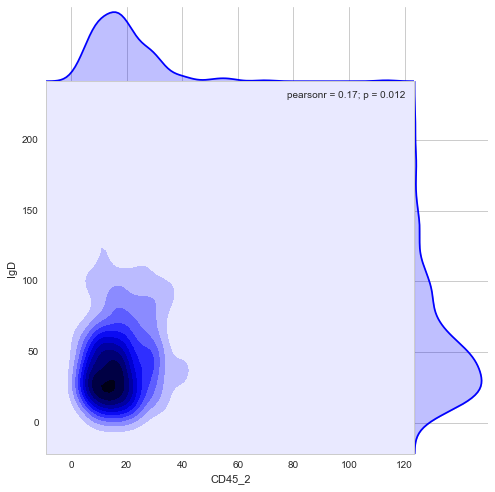

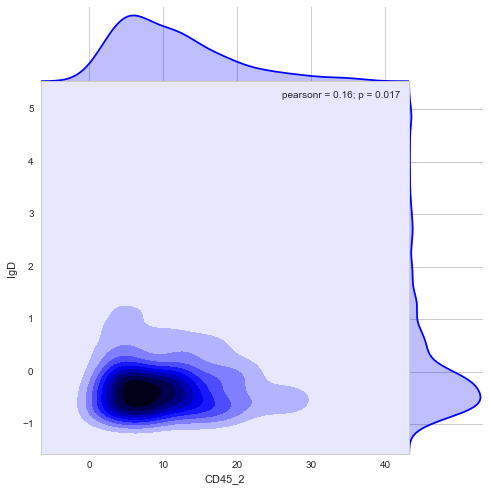

In [10]:
sns.set()
sns.set_style("whitegrid")
sns.jointplot(data_plot['CD45_2'][data_plot['cell type'] == 'IgDpos IgMpos B cells'],
              data_plot['IgD'][data_plot['cell type'] == 'IgDpos IgMpos B cells'],
              kind="kde", size=7, space=0, color="b");

sns.jointplot(data_plot['CD45_2'][data_plot['cell type'] == 'Classical Monocytes'],
              data_plot['IgD'][data_plot['cell type'] == 'Classical Monocytes'],
              kind="kde", size=7, space=0, color="b");


## The pipeline

For submitting at the [RAMP site](http://ramp.studio), you will have to write two classes, saved in two different files:   
* the class `FeatureExtractor`, which will be used to extract features for classification from the dataset and produce a numpy array of size (number of samples $\times$ number of features). 
* a class `Classifier` to predict survival

### Feature extractor

The feature extractor implements a `transform` member function. It is saved in the file [`submissions/starting_kit/feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py). It receives the pandas dataframe `X_df` defined at the beginning of the notebook. It should produce a numpy array representing the extracted features, which will then be used for the classification. The starting kit feature extractor simply converts the pandas dataframe into a numerical array, withough any modification or selection of the features.

Note that the following code cells are *not* executed in the notebook. The notebook saves their contents in the file specified in the first line of the cell, so you can edit your submission before running the local test below and submitting it at the RAMP site.

In [11]:
%%file submissions/starting_kit/feature_extractor.py
class FeatureExtractor():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass

    def transform(self, X_df):
        X_array = X_df.values
        return X_array



Overwriting submissions/starting_kit/feature_extractor.py


### Classifier

The classifier follows a classical scikit-learn classifier template. It should be saved in the file [`submissions/starting_kit/classifier.py`](/edit/submissions/starting_kit/classifier.py). In its simplest form it takes a scikit-learn pipeline, assigns it to `self.clf`, then calls its `fit` and `predict_proba` functions in the corresponding member funtions.

In [12]:
%%file submissions/starting_kit/classifier.py
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier


class Classifier(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.clf = RandomForestClassifier(
            n_estimators=2, max_leaf_nodes=2, random_state=61)
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)



Overwriting submissions/starting_kit/classifier.py


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `classifier.py` and `feature_extractor.py` are in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the data `train.csv` and `test.csv` are in [`data`](/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [13]:
!ramp_test_submission

Testing Cell population identification from single-cell mass cytometry data
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
	train bac = 0.04
	valid bac = 0.04
	test bac = 0.04
	train acc = 0.427
	valid acc = 0.416
	test acc = 0.396
	train nll = 1.72
	valid nll = 1.71
	test nll = 1.78
CV fold 1
	train bac = 0.04
	valid bac = 0.05
	test bac = 0.04
	train acc = 0.415
	valid acc = 0.453
	test acc = 0.396
	train nll = 1.73
	valid nll = 1.66
	test nll = 1.78
CV fold 2
	train bac = 0.04
	valid bac = 0.04
	test bac = 0.04
	train acc = 0.408
	valid acc = 0.471
	test acc = 0.394
	train nll = 1.74
	valid nll = 1.61
	test nll = 1.77
CV fold 3
	train bac = 0.04
	valid bac = 0.04
	test bac = 0.04
	train acc = 0.448
	valid acc = 0.357
	test acc = 0.396
	train nll = 1.65
	valid nll = 1.92
	test nll = 1.79
----------------------------
train bac = 0.04 ± 0.0
train acc = 0.425 ± 0.0152
train nll = 1.71 ± 0.032
valid bac = 0.04 ± 0.002
valid a

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good feature extractor and classifier, you can submit them to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [mouse cytometry](http://www.ramp.studio/events/mouse_cytometry) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/mouse_cytometry/sandbox) and copy-paste (or upload) [`feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py) and [`classifier.py`](/edit/submissions/starting_kit/classifier.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/mouse_cytometry/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/mouse_cytometry/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/mouse_cytometry/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train bac = 0.04 ± 0.0
train acc = 0.425 ± 0.0152
train nll = 1.71 ± 0.032
valid bac = 0.04 ± 0.002
valid acc = 0.424 ± 0.0437
valid nll = 1.72 ± 0.116
test bac = 0.04 ± 0.0
test acc = 0.395 ± 0.0006
test nll = 1.78 ± 0.006
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/mouse_cytometry/leaderboard)) is [balanced accuracy](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/score_types/balanced_accuracy.py), more precisely the balanced [macro-averaged recall](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/score_types/macro_averaged_recall.py), so the line that is relevant in the output of `ramp_test_submission` is `valid bac = 0.04 ± 0.0`. When the score is good enough, you can submit it at the RAMP.

## Working in the notebook

When you are developing and debugging your submission, you may want to stay in the notebook and execute the workflow step by step. You can import `problem.py` and call the ingredients directly, or even deconstruct the code from [ramp-workflow](https://github.com/paris-saclay-cds/ramp-workflow).

In [14]:
import imp
problem = imp.load_source('', 'problem.py')

Get the training data.

In [15]:
X_train, y_train = problem.get_train_data()

Get the first cv fold, creating training and validation indices.

In [16]:
train_is, test_is = list(problem.get_cv(X_train, y_train))[0]
test_is

array([    0,     1,     2, ..., 15997, 15998, 15999])

Train your starting kit.

In [17]:
fe, clf = problem.workflow.train_submission(
    'submissions/starting_kit', X_train, y_train, train_is)

Get the full prediction (train and validation).

In [18]:
y_pred = problem.workflow.test_submission((fe, clf), X_train)

Print the training and validation scores.

In [19]:
score_function = problem.score_types[0]

`score_function` is callable, wrapping scikit-learn's `recall_score(..., average='macro')`. It expects the label index vectors, so it's easier if we wrap the predictions into `rampwf.prediction_types.multiclass` which does these transformations and call `score_function.score_function` which takes this type as input.

In [20]:
ground_truth = problem.Predictions(y_true=y_train)
prediction = problem.Predictions(y_pred=y_pred)

In [21]:
score_train = score_function.score_function(ground_truth, prediction, train_is)
print(score_train)

0.0423560409145


In [22]:
score_valid = score_function.score_function(ground_truth, prediction, test_is)
print(score_valid)

0.0424539296411


Get the independent test data.

In [23]:
X_test, y_test = problem.get_test_data()

Test the submission on it.

In [24]:
y_test_pred = problem.workflow.test_submission((fe, clf), X_test)

In [25]:
ground_truth_test = problem.Predictions(y_true=y_test)
prediction_test = problem.Predictions(y_pred=y_test_pred)

In [26]:
score_test = score_function.score_function(ground_truth_test, prediction_test)
print(score_test)

0.041970903861


If you want to execute training step by step, go to the [`feature_extractor_classifier`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/feature_extractor_classifier.py), [`feature_extractor`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/feature_extractor.py), and [`classifier`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/classifier.py) workflows and deconstruct them.

First load the submission files and instantiate the feature extractor and regressor objects.

In [27]:
feature_extractor = imp.load_source(
    '', 'submissions/starting_kit/feature_extractor.py')
fe = feature_extractor.FeatureExtractor()
classifier = imp.load_source(
    '', 'submissions/starting_kit/classifier.py')
clf = classifier.Classifier()

Select the training folds.

In [28]:
X_train_train_df = X_train.iloc[train_is]
y_train_train = y_train[train_is]

Fit the feature extractor.

In [29]:
fe.fit(X_train_train_df, y_train_train)

Transform the training dataframe into numpy array.

In [30]:
X_train_train_array = fe.transform(X_train_train_df)

Fit the classifier.

In [31]:
clf.fit(X_train_train_array, y_train_train)

Transform the _whole_ (training + validation) dataframe into a numpy array and compute the prediction.

In [32]:
X_train_array = fe.transform(X_train)
y_pred = clf.predict_proba(X_train_array)
ground_truth = problem.Predictions(y_true=y_train)
prediction = problem.Predictions(y_pred=y_pred)

Print the errors.

In [33]:
score_train = score_function.score_function(ground_truth, prediction, train_is)
print(score_train)

0.0423560409145


In [34]:
score_valid = score_function.score_function(ground_truth, prediction, test_is)
print(score_valid)

0.0424539296411


## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=mouse cytometry notebook).